In [1]:
SF = 10
engine='chdb'

# Install Package

In [2]:
!pip install datafusion
!pip install chdb        --pre   --upgrade
!pip install duckdb      --upgrade
!pip install deltalake   --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 89.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 MB 11.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 83.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.0.0
    Uninstalling duckdb-1.0.0:
      Successfully uninstalled duckdb-1.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 43.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: deltalake
    Found existing installation: deltalake 0.18.2
    Uninstalling deltalake-0.18.2:
      Successfully uninstalled deltalake-0.18.2


**<mark><u>Import</u></mark>**

In [3]:
import duckdb
import pathlib
from   deltalake import convert_to_deltalake
import time
import pandas as pd
from   deltalake.writer import write_deltalake
from   datetime import datetime
from   chdb import session as chs
from   psutil import *
from   datafusion import SessionContext

In [4]:
core=cpu_count()
core

2

# Generate Delta

In [21]:
%%time
Table_Path = '/lakehouse/default/Tables'
Files_Path = '/lakehouse/default/Files'
if not pathlib.Path(f'{Table_Path}/CH{SF}').exists():
  if not pathlib.Path(f'{Files_Path}/tpch_{SF}.duckdb').exists():
    print('generate new database')
    pathlib.Path(f'{Files_Path}').mkdir(parents=True, exist_ok=True)
    con=duckdb.connect(f'{Files_Path}/tpch_{SF}.duckdb')
    con.sql(f"CALL dbgen(sf={SF}) ")
  else:
     con=duckdb.connect(f'{Files_Path}/tpch_{SF}.duckdb',read_only=1)
     print('DB exist')
  for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part']:
      pathlib.Path(f'{Table_Path}/CH{SF}/{tbl}').mkdir(parents=True, exist_ok=True)
      con.sql(f"""
      COPY (SELECT * FROM {tbl}) TO '{Table_Path}/CH{SF}/{tbl}' (FORMAT PARQUET,PER_THREAD_OUTPUT TRUE)
       """)
      convert_to_deltalake(f'{Table_Path}/CH{SF}/{tbl}',storage_options={"allow_unsafe_rename":"true"})
  con.close()
else:
  print("Already Generated")

Already Generated
CPU times: user 1.12 ms, sys: 99 µs, total: 1.22 ms
Wall time: 1.86 ms


# SQL Query

In [22]:
# @title
sql=(f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;



WITH cheapest_part AS (
    SELECT
        MIN(ps.ps_supplycost) AS cp_lowest,
        p.p_partkey AS cp_partkey
    FROM part p
    JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
    JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
    JOIN nation n ON s.s_nationkey = n.n_nationkey
    JOIN region r ON n.n_regionkey = r.r_regionkey
    WHERE r.r_name = 'EUROPE'
    GROUP BY p.p_partkey
)
SELECT
    s.s_acctbal,
    s.s_name,
    n.n_name,
    p.p_partkey,
    p.p_mfgr,
    s.s_address,
    s.s_phone,
    s.s_comment
FROM part p
JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
JOIN region r ON n.n_regionkey = r.r_regionkey
JOIN cheapest_part cp ON ps.ps_supplycost = cp.cp_lowest AND cp.cp_partkey = p.p_partkey
WHERE p.p_size = 15
  AND p.p_type LIKE '%BRASS'
  AND r.r_name = 'EUROPE'
ORDER BY s.s_acctbal DESC,
         n.n_name,
         s.s_name,
         p.p_partkey
LIMIT 10;









SELECT
    l.l_orderkey,
    SUM(l.l_extendedprice * (1 - l.l_discount)) AS revenue,
    o.o_orderdate,
    o.o_shippriority
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON l.l_orderkey = o.o_orderkey
WHERE
    c.c_mktsegment = 'BUILDING'
    AND o.o_orderdate < CAST('1995-03-15' AS DATE)
    AND l.l_shipdate > CAST('1995-03-15' AS DATE)
GROUP BY
    l.l_orderkey,
    o.o_orderdate,
    o.o_shippriority
ORDER BY
    revenue DESC,
    o.o_orderdate
LIMIT 10;









select
--Query04
	o_orderpriority,
	count(*) as order_count
from
	orders
where
	o_orderdate >= cast('1993-07-01' as date)
	and o_orderdate < cast('1993-10-01' as date)
	and o_orderkey in (
		select
			l_orderkey
		from
			lineitem
		where
			l_commitdate < l_receiptdate
	)
group by
	o_orderpriority
order by
	o_orderpriority;




SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM lineitem
inner join (select * from orders where o_orderdate >= '1994-01-01' AND o_orderdate < '1995-01-01') as x
on l_orderkey = x.o_orderkey
left join supplier
on l_suppkey = s_suppkey
left join customer
on o_custkey = c_custkey and
c_nationkey = s_nationkey
left join nation
on s_nationkey = n_nationkey
inner join ( select * from region where r_name = 'ASIA') as xx
on n_regionkey = xx.r_regionkey

GROUP BY
    n_name
ORDER BY
    revenue DESC;


SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;







SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM (
    SELECT
        n1.n_name AS supp_nation,
        n2.n_name AS cust_nation,
        EXTRACT(YEAR FROM l.l_shipdate) AS l_year,
        l.l_extendedprice * (1 - l.l_discount) AS volume
    FROM
        supplier s
    JOIN lineitem l ON s.s_suppkey = l.l_suppkey
    JOIN orders o ON o.o_orderkey = l.l_orderkey
    JOIN customer c ON c.c_custkey = o.o_custkey
    JOIN nation n1 ON s.s_nationkey = n1.n_nationkey
    JOIN nation n2 ON c.c_nationkey = n2.n_nationkey
    WHERE
        (n1.n_name = 'FRANCE' AND n2.n_name = 'GERMANY')
        OR (n1.n_name = 'GERMANY' AND n2.n_name = 'FRANCE')
        AND l.l_shipdate BETWEEN CAST('1995-01-01' AS DATE) AND CAST('1996-12-31' AS DATE)
) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;








SELECT
    --Query08
        EXTRACT( year  FROM  o_orderdate ) AS o_year,
        SUM(  CASE  WHEN n2.n_name = 'BRAZIL' THEN l_extendedprice * (1 - l_discount) ELSE 0  END ) / SUM(l_extendedprice * (1 - l_discount)) AS mkt_share
        FROM  lineitem
        inner join   (select o_custkey,o_orderdate, o_orderkey from  orders WHERE  o_orderdate BETWEEN CAST('1995-01-01' AS date) AND CAST('1996-12-31' AS date) ) xxx
        on l_orderkey = xxx.o_orderkey
        inner join  (select p_partkey from  part  where p_type = 'ECONOMY ANODIZED STEEL' ) z
        on  l_partkey = z.p_partkey
        left join    supplier
        on  l_suppkey = s_suppkey
        left join   customer
        on o_custkey = c_custkey
        left join   nation n1
        on c_nationkey = n1.n_nationkey
        left join   nation n2
        on s_nationkey = n2.n_nationkey
        inner join  (select * from region where r_name = 'AMERICA') cc
        on  n1.n_regionkey = cc.r_regionkey




GROUP BY
    o_year
ORDER BY
    o_year;










SELECT
    --Query09
    n_name AS nation,
    EXTRACT( year  FROM o_orderdate ) AS o_year,
    sum(l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity) AS sum_profit
        FROM lineitem
        inner join ( select p_partkey from part where  p_name LIKE '%green%') xx
        on  l_partkey = xx.p_partkey
        left join orders
        on  l_orderkey =o_orderkey
        left join  partsupp
        on  l_suppkey =ps_suppkey  AND  l_partkey = ps_partkey
        left join  supplier
        on    l_suppkey =s_suppkey
        left join nation
        on  n_nationkey = s_nationkey


GROUP BY
    n_name,
    o_year
ORDER BY
    n_name,
    o_year DESC;



SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM  lineitem
inner join ( select * from orders where o_orderdate >= '1993-10-01' AND o_orderdate < '1994-01-01') as xx
on l_orderkey = xx.o_orderkey
left join customer
on xx.o_custkey = c_custkey
left join nation
on c_nationkey = n_nationkey
WHERE  l_returnflag = 'R'

GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    ps.ps_partkey,
    SUM(ps.ps_supplycost * ps.ps_availqty) AS value
FROM
    partsupp ps
JOIN supplier s ON ps.ps_suppkey = s.s_suppkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
WHERE
    n.n_name = 'GERMANY'
GROUP BY
    ps.ps_partkey
HAVING
    SUM(ps.ps_supplycost * ps.ps_availqty) > (
        SELECT
            SUM(ps_inner.ps_supplycost * ps_inner.ps_availqty) * (0.0001 / {SF})
        FROM
            partsupp ps_inner
        JOIN supplier s_inner ON ps_inner.ps_suppkey = s_inner.s_suppkey
        JOIN nation n_inner ON s_inner.s_nationkey = n_inner.n_nationkey
        WHERE
            n_inner.n_name = 'GERMANY'
    )
ORDER BY
    value DESC;









SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM lineitem
left join  orders
on o_orderkey = l_orderkey

WHERE  l_shipmode IN ('MAIL', 'SHIP')
       AND l_commitdate < l_receiptdate
       AND l_shipdate < l_commitdate
       AND l_receiptdate >=  '1994-01-01'  AND l_receiptdate < '1995-01-01'
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;








SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;








SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM  lineitem
left join part
on l_partkey = p_partkey
WHERE l_shipdate >= cast('1995-09-01' as date) AND l_shipdate < cast('1995-10-01' as date);








SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            l_suppkey
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue1
    )
ORDER BY
    s_suppkey;








SELECT
    --Query16
    p.p_brand,
    p.p_type,
    p.p_size,
    COUNT(DISTINCT ps.ps_suppkey) AS supplier_cnt
FROM
    partsupp ps
JOIN part p ON p.p_partkey = ps.ps_partkey
WHERE
    p.p_brand <> 'Brand#45'
    AND p.p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p.p_size IN (49, 14, 23, 45, 19, 3, 36, 9)
    AND ps.ps_suppkey NOT IN (
        SELECT
            s.s_suppkey
        FROM
            supplier s
        WHERE
            s.s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p.p_brand,
    p.p_type,
    p.p_size
ORDER BY
    supplier_cnt DESC,
    p.p_brand,
    p.p_type,
    p.p_size;









WITH part_avg AS (
    -- Query17
    SELECT
        (0.2 * AVG(l.l_quantity)) AS limit_qty,
        l.l_partkey AS lpk
    FROM lineitem l
    GROUP BY l.l_partkey
)
SELECT
    SUM(l.l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem l
JOIN part p ON p.p_partkey = l.l_partkey
JOIN part_avg pa ON p.p_partkey = pa.lpk
WHERE
    p.p_brand = 'Brand#23'
    AND p.p_container = 'MED BOX'
    AND l.l_quantity < pa.limit_qty;







SELECT
    --Query18
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice,
    SUM(l.l_quantity)
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON o.o_orderkey = l.l_orderkey
WHERE
    o.o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
GROUP BY
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice
ORDER BY
    o.o_totalprice DESC,
    o.o_orderdate
LIMIT
    100;






select
--Query19
sum(l_extendedprice* (1 - l_discount)) as revenue

from lineitem
join  part
ON p_partkey = l_partkey
where (
		p_brand = 'Brand#12'
		and p_container in ('SM CASE', 'SM BOX', 'SM PACK', 'SM PKG')
		and l_quantity >= 1 and l_quantity <= 1 + 10
		and p_size between 1 and 5
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	) or ( p_partkey = l_partkey
		and p_brand = 'Brand#23'
		and p_container in ('MED BAG', 'MED BOX', 'MED PKG', 'MED PACK')
		and l_quantity >= 10 and l_quantity <= 10 + 10
		and p_size between 1 and 10
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	) or ( p_partkey = l_partkey
		and p_brand = 'Brand#34'
		and p_container in ('LG CASE', 'LG BOX', 'LG PACK', 'LG PKG')
		and l_quantity >= 20 and l_quantity <= 20 + 10
		and p_size between 1 and 15
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	);





--Query20
with availability_part_supp as(
	    select 0.5 * sum(l_quantity) as ps_halfqty, l_partkey as pkey, l_suppkey as skey
	    from lineitem
	    where l_shipdate >= cast('1994-01-01' as date)
	    and l_shipdate < cast('1995-01-01' as date)
	    group by pkey, skey
)
select s_name, s_address
from supplier, nation
where s_suppkey in (
	    select ps_suppkey
	    from partsupp, availability_part_supp
	    where ps_partkey in (
		        select p_partkey
			        from part
				        where p_name like 'forest%'
					    )
					    and ps_partkey = pkey
					    and ps_suppkey = skey
					    and ps_availqty > ps_halfqty
				)
				and s_nationkey = n_nationkey
				and n_name = 'CANADA'
				order by s_name;






SELECT
    --Query21
    s.s_name,
    COUNT(*) AS numwait
FROM
    supplier s
JOIN lineitem l1 ON s.s_suppkey = l1.l_suppkey
JOIN orders o ON o.o_orderkey = l1.l_orderkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
WHERE
    o.o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND l1.l_orderkey IN (
        SELECT l_orderkey
        FROM lineitem
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND l1.l_orderkey NOT IN (
        SELECT l_orderkey
        FROM lineitem
        WHERE l_receiptdate > l_commitdate
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND n.n_name = 'SAUDI ARABIA'
GROUP BY s.s_name
ORDER BY numwait DESC, s.s_name
LIMIT 100;





select
--Query22
cntrycode,
	count(*) as numcust,
	sum(c_acctbal) as totacctbal
from ( select
			substring(c_phone from 1 for 2) as cntrycode,
			c_acctbal
		from customer
		where substring(c_phone from 1 for 2) in
				('13', '31', '23', '29', '30', '18', '17')
			and c_acctbal > (
				select avg(c_acctbal)
				from customer
				where c_acctbal > 0
					and substring(c_phone from 1 for 2) in
						('13', '31', '23', '29', '30', '18', '17')
			)
			and c_custkey not in (
				select o_custkey
				from orders
			)
	) as custsale
group by cntrycode
order by cntrycode;

''')

# Utility Function

In [23]:
def execute_query(engine, sql_script):
    df = pd.DataFrame(columns=['dur','query'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            try :
             engine.sql(value).show()
             stop = time.time()
             duration = stop-start
            except  Exception as er:
              print(er)
              duration = float('nan')
            print(duration)
            row = {'dur': duration,'query':index}
            df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
    return df

In [24]:
def chdb_tpch():
    start = time.time()
    sess = chs.Session()
    sess.query("CREATE DATABASE IF NOT EXISTS db_xxx ; use db_xxx")
    for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
        sess.query(f'create or replace view {tbl}  as select * from file("/lakehouse/default/Tables/CH{SF}/{tbl}/*.parquet", Parquet)')
    stop = time.time()
    external_table_duration = stop-start
    df=execute_query(sess, sql)
    df.at[0,'dur'] = df.at[0, 'dur'] + external_table_duration
    df['Engine'] = 'chdb'
    df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    df['sf'] = SF
    df['cpu'] = core
    df['test'] = 'tpch'
    write_deltalake('/lakehouse/default/Tables/dbo/result',df,mode="append",storage_options={"allow_unsafe_rename":"true"})
    return "done"

In [25]:
def datafusion_tpch():
    start = time.time()
    ctx = SessionContext()
    for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
        ctx.register_parquet(f'{tbl}',  f'/lakehouse/default/Tables/CH{SF}/{tbl}/*.parquet')
    stop = time.time()
    external_table_duration = stop-start
    df = execute_query(ctx,sql)
    df.at[0,'dur'] = df.at[0, 'dur'] + external_table_duration
    df['Engine'] = 'datafusion'
    df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    df['sf'] = SF
    df['cpu'] = core
    df['test'] = 'tpch'
    write_deltalake('/lakehouse/default/Tables/dbo/result',df,mode="append",storage_options={"allow_unsafe_rename":"true"}) 
    return "done"

In [26]:
def duckdb_tpch():
    start = time.time()
    for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
        duckdb.sql(f''' CREATE or replace View  {tbl} AS SELECT * FROM delta_scan('/lakehouse/default/Tables/CH{SF}/{tbl}') ''')
    stop = time.time()
    external_table_duration = stop-start
    df=execute_query(duckdb, sql)
    df.at[0,'dur'] = df.at[0, 'dur'] + external_table_duration
    df['Engine'] = 'duckdb'
    df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    df['sf'] = SF
    df['cpu'] = core
    df['test'] = 'tpch'
    write_deltalake('/lakehouse/default/Tables/dbo/result',df,mode="append",storage_options={"allow_unsafe_rename":"true"}) 
    return "done"

In [27]:
def native_tpch():
    start = time.time()
    con=duckdb.connect(f'/lakehouse/default/Files/tpch_{SF}.duckdb',read_only=True)
    stop = time.time()
    external_table_duration = stop-start
    df=execute_query(con, sql)
    df.at[0,'dur'] = df.at[0, 'dur'] + external_table_duration
    df['Engine'] = 'duckdb_native'
    df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    df['sf'] = SF
    df['cpu'] = core
    df['test'] = 'tpch'
    write_deltalake('/lakehouse/default/Tables/dbo/result',df,mode="append",storage_options={"allow_unsafe_rename":"true"}) 
    return "done"

In [28]:
start = time.time()
eval(f"{engine}_tpch()")
print(f'{engine} :' + str(time.time()-start))

Query1
9998.97,"Supplier#000037519","RUSSIA",587518,"Manufacturer#5","tgI0aw7ZH,vFCH","32-187-457-4262","ts after the slowly ironic requests haggle fluffily according to the blithely bold ideas. darin"
9967.64,"Supplier#000037131","UNITED KINGDOM",212122,"Manufacturer#4","4GuwTGu2npey5cMLNw1tNmLaT0rNwgb2jpiK,","33-957-450-3258","te quickly. pending pinto beans eat f"
9967.6,"Supplier#000028837","ROMANIA",278836,"Manufacturer#3","LqQdPou57tmHHJKlCNqgutRxG","29-105-576-2294"," pinto beans. even accounts cajole abou"
9967.45,"Supplier#000002302","FRANCE",64798,"Manufacturer#4","wems  3YggC7QhknXxkm7IPtEl","16-486-165-5642","ake after the silent, even packages. quickl"
9961.34,"Supplier#000016272","UNITED KINGDOM",78768,"Manufacturer#3","fK8AemIJpVxC9UVf7HcRlzx","33-964-689-9063","eans. furiously express pinto beans detect carefully even dependencies. q"
9961.34,"Supplier#000016272","UNITED KINGDOM",178762,"Manufacturer#2","fK8AemIJpVxC9UVf7HcRlzx","33-964-689-9063","eans. furiously expres

/tmp/ipykernel_63/2701879410.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)


In [29]:
start = time.time()
eval(f"{engine}_tpch()")
print(f'{engine} :' + str(time.time()-start))

9998.97,"Supplier#000037519","RUSSIA",587518,"Manufacturer#5","tgI0aw7ZH,vFCH","32-187-457-4262","ts after the slowly ironic requests haggle fluffily according to the blithely bold ideas. darin"
9967.64,"Supplier#000037131","UNITED KINGDOM",212122,"Manufacturer#4","4GuwTGu2npey5cMLNw1tNmLaT0rNwgb2jpiK,","33-957-450-3258","te quickly. pending pinto beans eat f"
9967.6,"Supplier#000028837","ROMANIA",278836,"Manufacturer#3","LqQdPou57tmHHJKlCNqgutRxG","29-105-576-2294"," pinto beans. even accounts cajole abou"
9967.45,"Supplier#000002302","FRANCE",64798,"Manufacturer#4","wems  3YggC7QhknXxkm7IPtEl","16-486-165-5642","ake after the silent, even packages. quickl"
9961.34,"Supplier#000016272","UNITED KINGDOM",78768,"Manufacturer#3","fK8AemIJpVxC9UVf7HcRlzx","33-964-689-9063","eans. furiously express pinto beans detect carefully even dependencies. q"
9961.34,"Supplier#000016272","UNITED KINGDOM",178762,"Manufacturer#2","fK8AemIJpVxC9UVf7HcRlzx","33-964-689-9063","eans. furiously express pinto

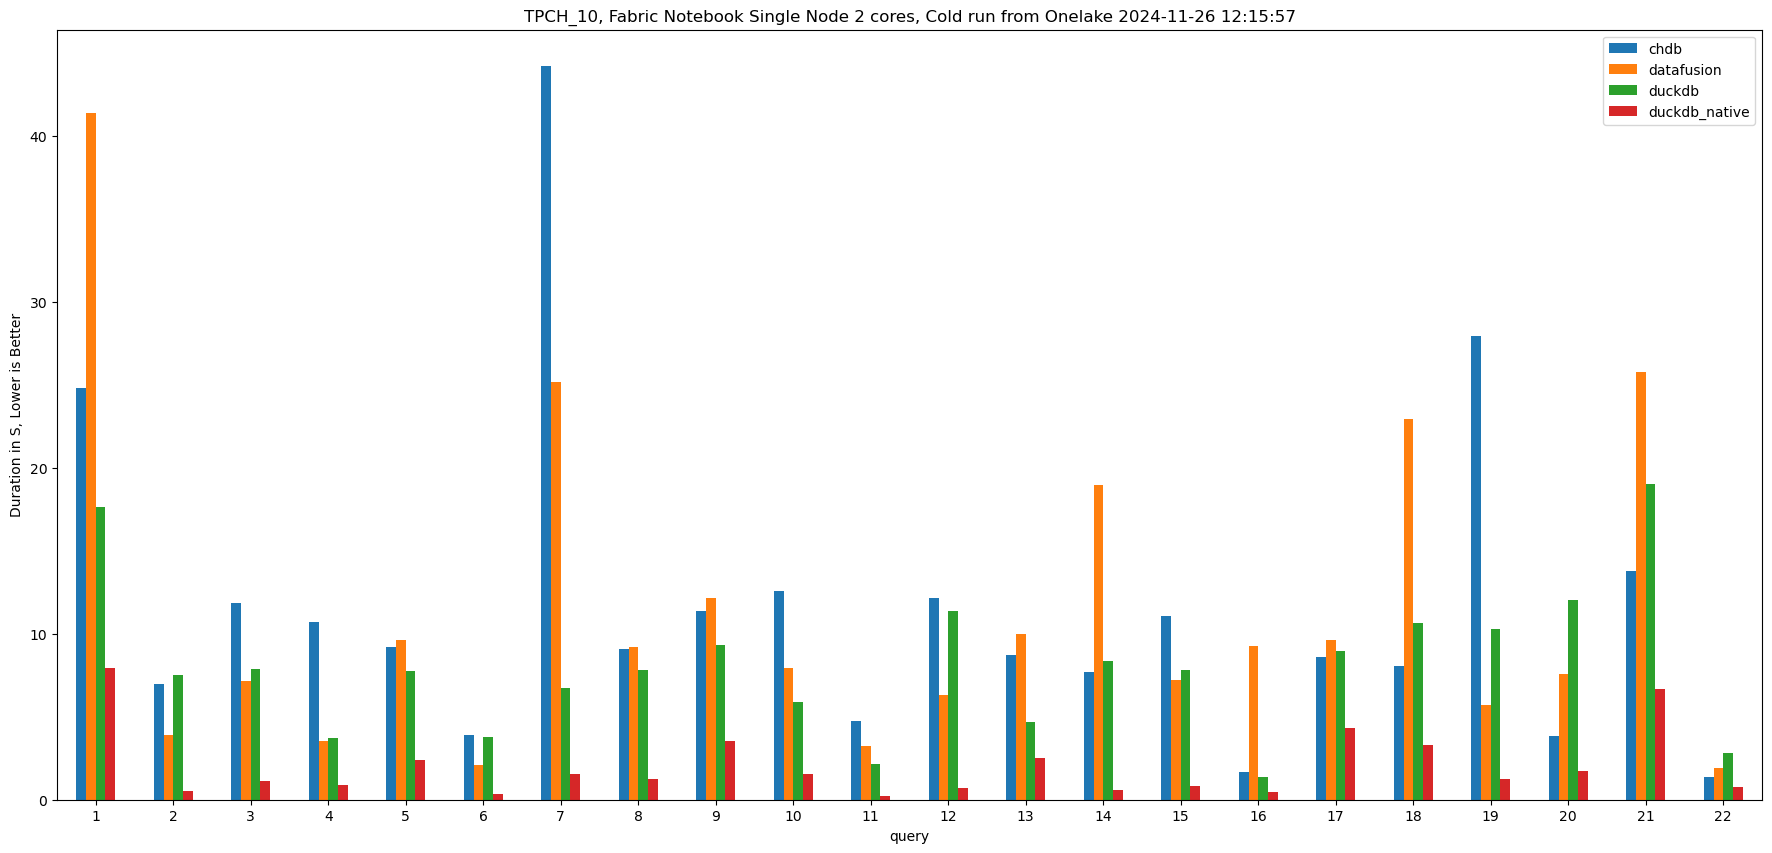

In [5]:
pv = duckdb.sql(f"""PIVOT ( select Engine,sf, dur, query from delta_scan('/lakehouse/default/Tables/dbo/result' ) where sf = {SF} and test  ='tpch') ON Engine using avg(dur) order by query""")
xx = duckdb.sql(f" select query, sum(COLUMNS(*exclude(sf,query))) from pv  group by all order by query  ").df()
ax = xx.plot.bar(rot=0,x='query',title=f"TPCH_{SF}, Fabric Notebook Single Node {core} cores, Cold run from Onelake " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'),ylabel='Duration in S, Lower is Better',figsize=(22,10))

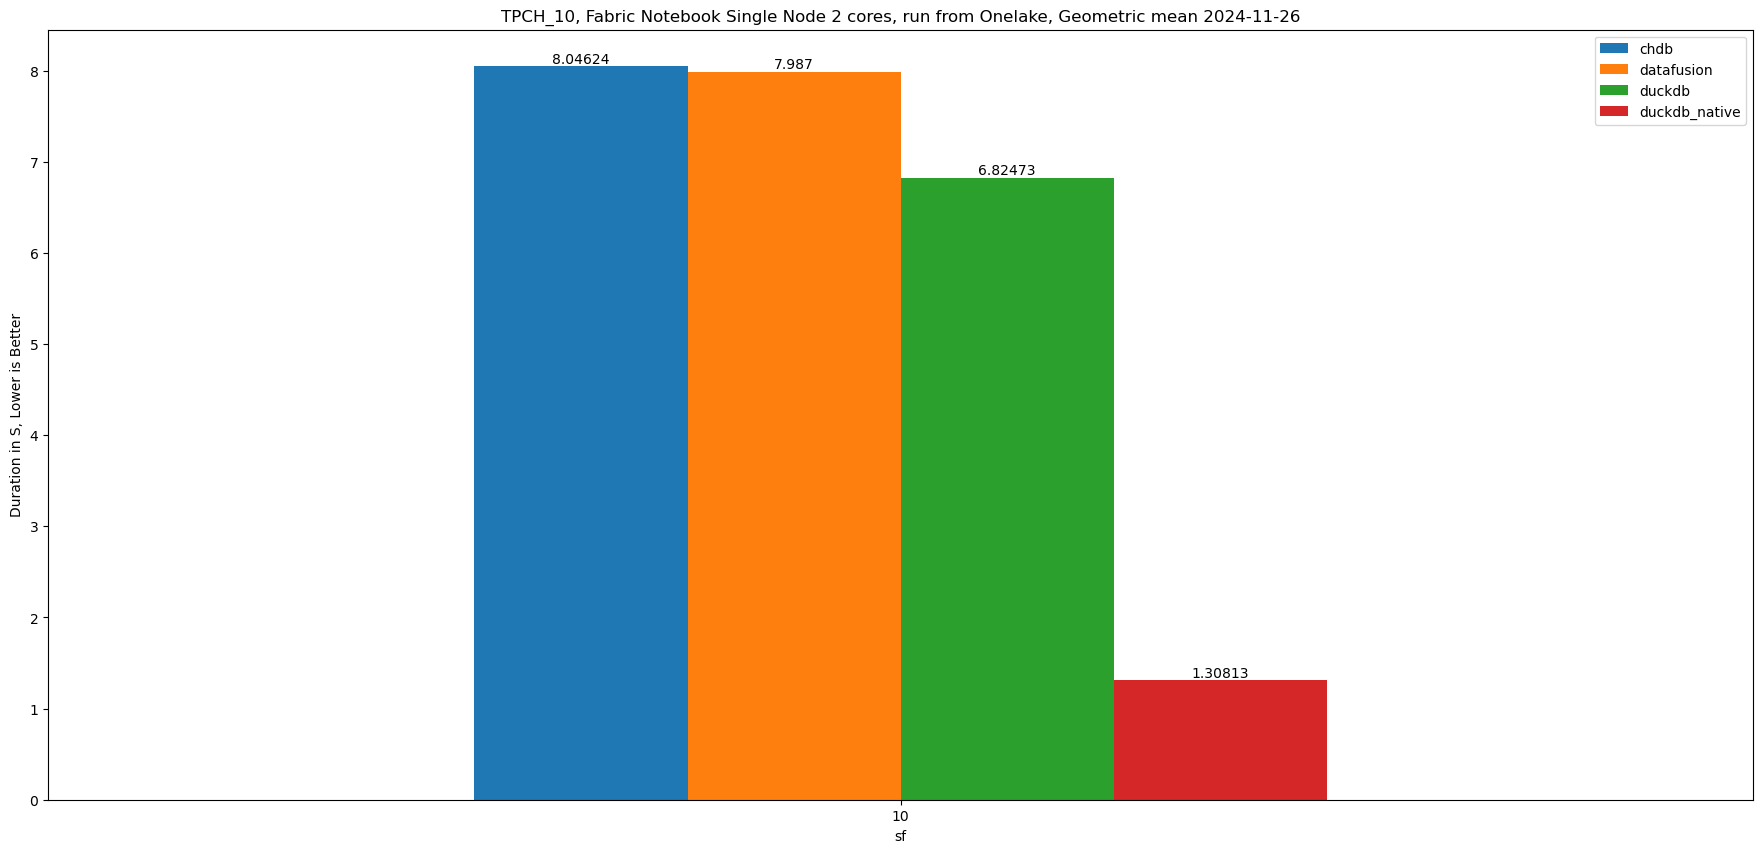

In [6]:
pv = duckdb.sql(f"""PIVOT ( select Engine,sf, dur, query from delta_scan('/lakehouse/default/Tables/dbo/result' ) where sf = {SF} and test  ='tpch' and query !=7 ) ON Engine using avg(dur) order by query""")
xx = duckdb.sql(f" select sf, geomean(COLUMNS(*exclude(sf,query))) from pv  group by all  ").df()
ax = xx.plot.bar(rot=0,x='sf',title=f"TPCH_{SF}, Fabric Notebook Single Node {core} cores, run from Onelake, Geometric mean " + datetime.now().strftime('%Y-%m-%d'),ylabel='Duration in S, Lower is Better',figsize=(22,10))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

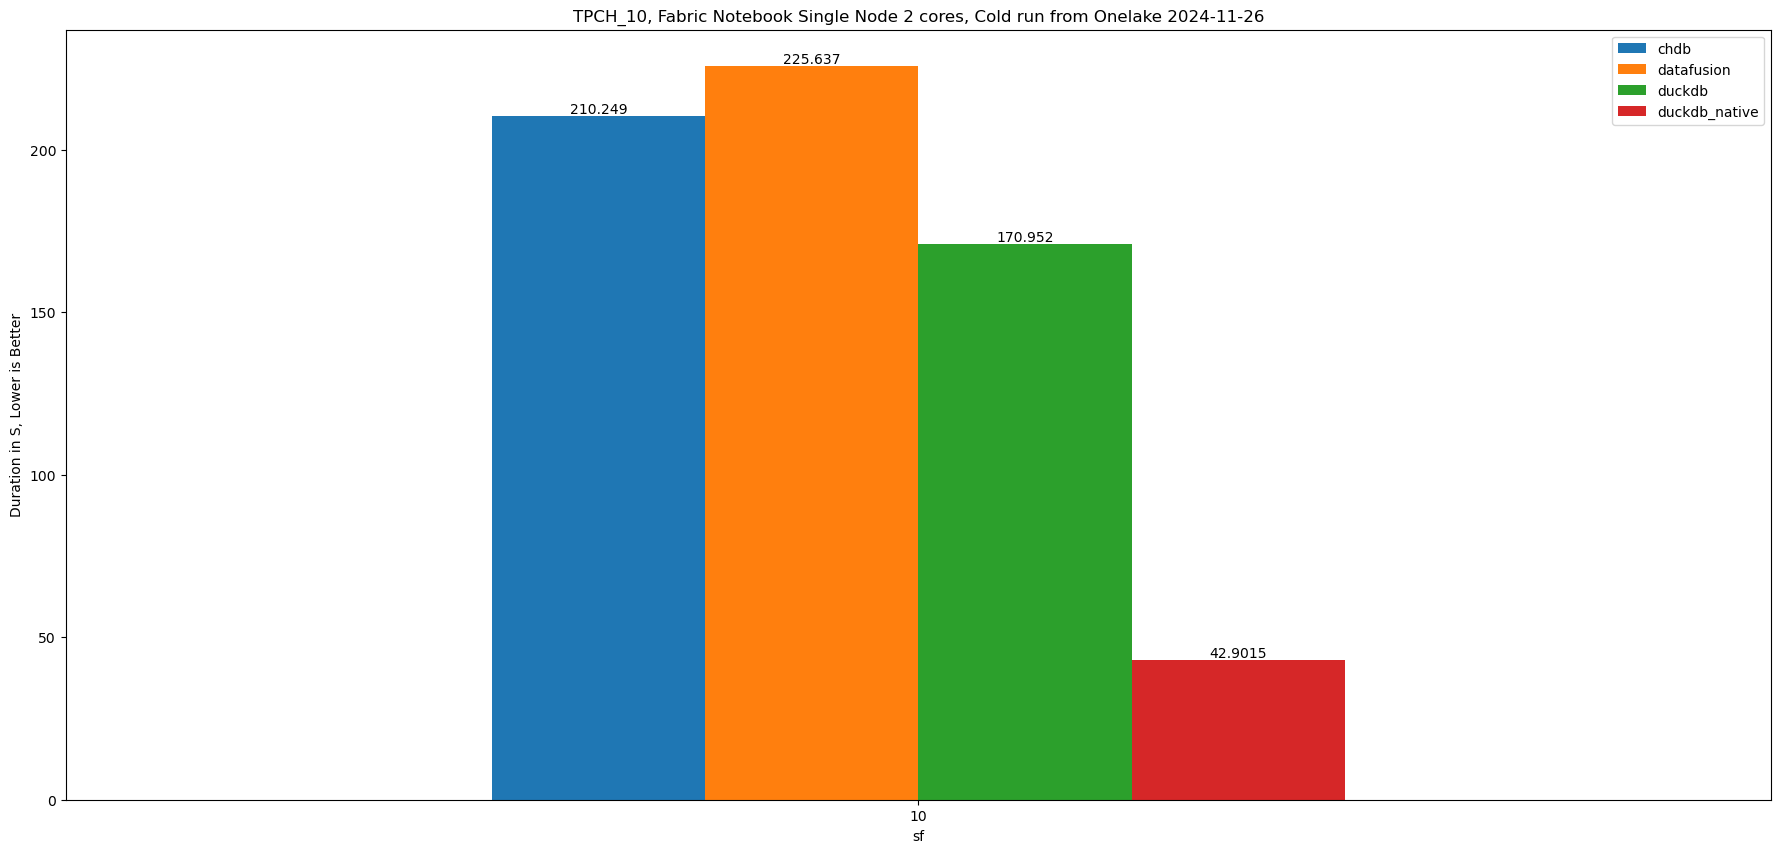

In [7]:
pv = duckdb.sql(f"""PIVOT ( select Engine,sf, dur, query from delta_scan('/lakehouse/default/Tables/dbo/result' ) where sf = {SF} and test  ='tpch' and query !=7 ) ON Engine using avg(dur) order by query""")
xx = duckdb.sql(f" select sf, sum(COLUMNS(*exclude(sf,query))) from pv  group by all  ").df()
ax = xx.plot.bar(rot=0,x='sf',title=f"TPCH_{SF}, Fabric Notebook Single Node {core} cores, Cold run from Onelake " + datetime.now().strftime('%Y-%m-%d'),ylabel='Duration in S, Lower is Better',figsize=(22,10))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')